# Transfer Learning

## Import packages

In [1]:

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 Load the CIFAR10 dataset and build cnn model

In [2]:
model = Sequential(name="cifar10")
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [3]:
model.summary()

Model: "cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1849

In [4]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [6]:

# initial cifar image shape
print(tf.shape(train_images))
print(tf.shape(test_images))
print(tf.shape(train_labels))
print(tf.shape(test_labels))

tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([10000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000     1], shape=(2,), dtype=int32)
tf.Tensor([10000     1], shape=(2,), dtype=int32)


In [7]:
# initial cifar image shape
print(tf.shape(train_labels))

tf.Tensor([50000     1], shape=(2,), dtype=int32)


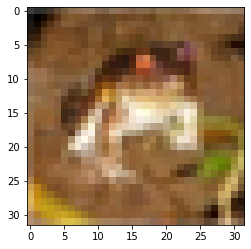

In [8]:
plt.imshow(train_images[0])

In [9]:
x_train = train_images / 255
x_test = test_images / 255

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

y_train = to_categorical(train_labels, NUM_CLASSES)
y_test = to_categorical(test_labels, NUM_CLASSES)

In [10]:


print(tf.shape(x_train))
print(tf.shape(y_train))

tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000    10], shape=(2,), dtype=int32)


## 1.2 Train this CNN for 10 epochs or more using a batch size of 32

In [11]:

epochs = 15
batch_size = 32

with tf.device('/device:GPU:0'):
    model.fit(x_train,
              y_train,
              validation_data=(x_test, y_test),
              epochs=epochs,
              batch_size=batch_size,
              shuffle=True)

Epoch 1/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5412 - accuracy: 0.4340 - val_loss: 1.2252 - val_accuracy: 0.5623
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1783 - accuracy: 0.5794 - val_loss: 0.9918 - val_accuracy: 0.6444
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0400 - accuracy: 0.6318 - val_loss: 0.9289 - val_accuracy: 0.6724
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9450 - accuracy: 0.6660 - val_loss: 0.8736 - val_accuracy: 0.6939
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8813 - accuracy: 0.6903 - val_loss: 0.8438 - val_accuracy: 0.7043
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8297 - accuracy: 0.7075 - val_loss: 0.7926 - val_accuracy: 0.7202
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7862 - accuracy: 0.7241 - val_loss: 0.7698 - val_accuracy:

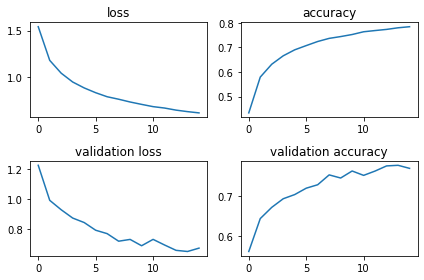

In [12]:

history = model.history.history

fig = plt.figure()

loss = fig.add_subplot(221)
loss.set_title('loss')
loss.plot(history['loss'])

accuracy = fig.add_subplot(222)
accuracy.set_title('accuracy')
accuracy.plot(history['accuracy'])

val_loss = fig.add_subplot(223)
val_loss.set_title('validation loss')
val_loss.plot(history['val_loss'])

val_accuracy = fig.add_subplot(224)
val_accuracy.set_title('validation accuracy')
val_accuracy.plot(history['val_accuracy'])

plt.tight_layout()
plt.show(fig)

In [13]:
model.save('train_cifar10.h5')

## 1.3 Analyze model performance

In [14]:
y_act = tf.reshape(test_labels, [len(test_labels)])
print(y_act[:2])

tf.Tensor([3 8], shape=(2,), dtype=uint8)


In [15]:
preds = model.predict(x_test)
y_pred = tf.math.argmax(preds, 1)
print(y_pred[:2])

tf.Tensor([3 8], shape=(2,), dtype=int64)


In [16]:
classification_report = metrics.classification_report(y_act, y_pred)
print(classification_report)

precision    recall  f1-score   support

           0       0.83      0.76      0.79      1000
           1       0.90      0.90      0.90      1000
           2       0.71      0.63      0.67      1000
           3       0.59      0.58      0.59      1000
           4       0.78      0.68      0.73      1000
           5       0.62      0.74      0.68      1000
           6       0.71      0.90      0.79      1000
           7       0.87      0.78      0.82      1000
           8       0.87      0.87      0.87      1000
           9       0.88      0.85      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



In [17]:
labels = [0,1,2,3,4,5,6,7,8,9]
confusion_matrix = metrics.confusion_matrix(y_act, y_pred, labels=labels, normalize=None)
print(confusion_matrix)

[[756  15  55  26  15  11  18  12  58  34]
 [ 12 902   0   7   2   7  14   0  17  39]
 [ 53   1 632  45  59  88  88  17  12   5]
 [  6   4  50 585  34 194  95  15   6  11]
 [ 12   3  64  64 681  41  88  40   6   1]
 [  5   0  27 142  24 741  33  22   2   4]
 [  5   2  12  52   4  18 902   2   2   1]
 [  7   1  25  46  45  76  12 776   7   5]
 [ 35  11  16  15   6   9  14   2 874  18]
 [ 17  67   7  14   2   5   6   9  25 848]]


## 1.4 Import VGG16 from keras without the top layer

In [18]:
# code snippets taken from Deep Learning for Vision Systems MEAP V08 livebook by Mohamed Elgendy

# download the model’s pretrained weights and save it in the variable base_model
# note that here we specified to keras to download the imagenet weights
# include_top is false to ignore the FC classifier part on top of the model
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (32, 32, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## 1.5 Freeze all layers in the pretrained VGG16 model

In [19]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = True
 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## 1.6 Extract the last layer from the VGG16 model

In [20]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

## 1.7 Add classification layers to the top of the model

In [33]:
output_layer = GlobalAveragePooling2D()(last_output)
output_layer = BatchNormalization()(output_layer)
output_layer = Dense(256, activation='relu')(output_layer)
output_layer = Dense(256, activation='relu')(output_layer)
output_layer = Dropout(0.5)(output_layer)
output_layer = Dense(10, activation='softmax')(output_layer)


# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=output_layer)
 
# print the new_model summary
new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

## 1.7a Create loss function for f-1 loss 

In [34]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [35]:
# new_model.compile(optimizer=tf.optimizers.SGD(lr=0.01, momentum=0.1, nesterov=True),
#                   loss=f1_loss, 
#                   metrics=['accuracy', f1])
new_model.compile(optimizer=tf.optimizers.SGD(lr=0.01, momentum=0.1, nesterov=True),
                  loss=CategoricalCrossentropy(from_logits=False, label_smoothing=0.2), 
                  metrics=['accuracy'])

## 1.8 Use the keras data generator function to load in cifar10 image data

In [36]:
# https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

x_train_vgg = train_images.astype("float")
x_test_vgg = test_images.astype("float")

mean = np.mean(train_images, axis=(0,1,2,3))
std = np.std(train_images, axis=(0,1,2,3))

x_train_vgg = (x_train_vgg - mean) / (std + 1e-7)
x_test_vgg = (x_test_vgg - mean) / (std + 1e-7)

data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

data_augmentation.fit(x_train_vgg)

## 1.9 Train pre-trained CNN for 10 epochs

In [37]:
epochs = 20
batch_size = 128

with tf.device('/device:GPU:0'):
    new_model.fit(data_augmentation.flow(x_train_vgg, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train_vgg) // batch_size,
                    validation_data=(x_test_vgg, y_test),
                    epochs=epochs)

Epoch 1/20
390/390 [==============================] - 20s 51ms/step - loss: 1.3458 - accuracy: 0.7752 - val_loss: 1.2402 - val_accuracy: 0.8162
Epoch 2/20
390/390 [==============================] - 20s 50ms/step - loss: 1.2167 - accuracy: 0.8391 - val_loss: 1.2069 - val_accuracy: 0.8197
Epoch 3/20
390/390 [==============================] - 20s 50ms/step - loss: 1.1823 - accuracy: 0.8540 - val_loss: 1.1909 - val_accuracy: 0.8265
Epoch 4/20
390/390 [==============================] - 20s 50ms/step - loss: 1.1598 - accuracy: 0.8658 - val_loss: 1.1713 - val_accuracy: 0.8410
Epoch 5/20
390/390 [==============================] - 20s 50ms/step - loss: 1.1410 - accuracy: 0.8741 - val_loss: 1.1399 - val_accuracy: 0.8541
Epoch 6/20
390/390 [==============================] - 20s 51ms/step - loss: 1.1232 - accuracy: 0.8826 - val_loss: 1.1170 - val_accuracy: 0.8648
Epoch 7/20
390/390 [==============================] - 20s 50ms/step - loss: 1.1122 - accuracy: 0.8883 - val_loss: 1.1271 - val_accuracy:

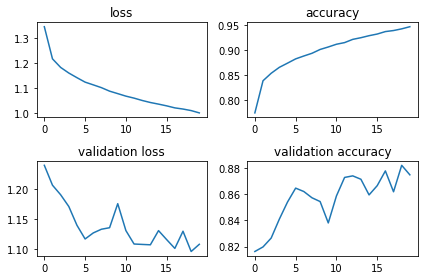

In [38]:
new_model_history = new_model.history.history

new_model_fig = plt.figure()

loss = new_model_fig.add_subplot(221)
loss.set_title('loss')
loss.plot(new_model_history['loss'])

accuracy = new_model_fig.add_subplot(222)
accuracy.set_title('accuracy')
accuracy.plot(new_model_history['accuracy'])

val_loss = new_model_fig.add_subplot(223)
val_loss.set_title('validation loss')
val_loss.plot(new_model_history['val_loss'])

val_accuracy = new_model_fig.add_subplot(224)
val_accuracy.set_title('validation accuracy')
val_accuracy.plot(new_model_history['val_accuracy'])

plt.tight_layout()
plt.show(new_model_fig)

In [39]:
vgg_preds = new_model.predict(x_test)
y_pred_vgg = tf.math.argmax(vgg_preds, 1)
print(y_pred_vgg[:2])

tf.Tensor([3 8], shape=(2,), dtype=int64)


In [40]:
y_act = tf.reshape(test_labels, [len(test_labels)])
classification_report = metrics.classification_report(y_act, y_pred_vgg)
print(classification_report)

precision    recall  f1-score   support

           0       0.69      0.78      0.73      1000
           1       0.99      0.39      0.56      1000
           2       0.81      0.66      0.73      1000
           3       0.56      0.59      0.58      1000
           4       0.35      0.96      0.52      1000
           5       0.80      0.46      0.58      1000
           6       0.83      0.71      0.76      1000
           7       0.94      0.52      0.67      1000
           8       0.68      0.93      0.78      1000
           9       0.89      0.48      0.63      1000

    accuracy                           0.65     10000
   macro avg       0.75      0.65      0.65     10000
weighted avg       0.75      0.65      0.65     10000



In [41]:
model.save('train_cifar10_vgg.h5')

## Visualize VGG16 CNN layers

In [42]:

vgg_layer_outputs = [layer.output for layer in new_model.layers[2:4]]
vgg_activation_model = models.Model(inputs=new_model.input, outputs=vgg_layer_outputs)
vgg_activations = vgg_activation_model.predict(tf.convert_to_tensor([x_test_vgg[0]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


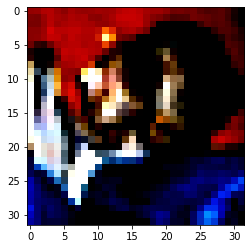

In [43]:
plt.imshow(x_test_vgg[0])

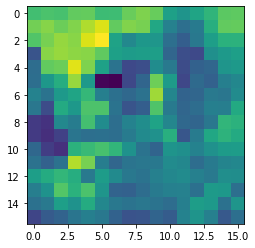

In [44]:
vgg_convolution_layer_idx = 1
vgg_convolution_filter_idx = 3
plt.imshow(vgg_activations[vgg_convolution_layer_idx][0, :, :, vgg_convolution_filter_idx])

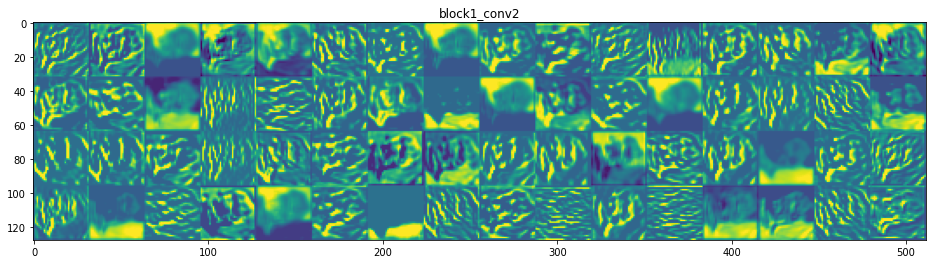

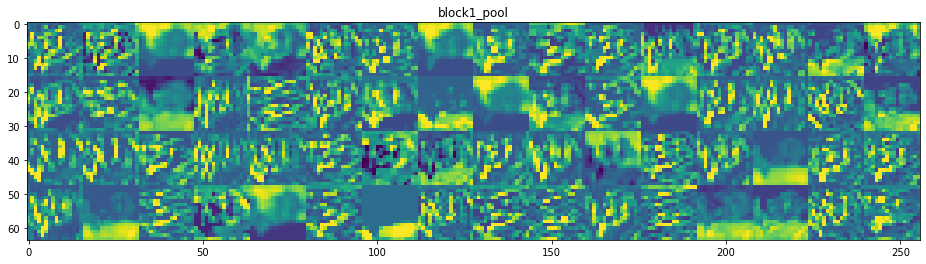

In [45]:
vgg_layer_names = []
for layer in new_model.layers[2:4]:
    vgg_layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(vgg_layer_names, vgg_activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')